# Backtest Result Comparisons

# Import files

If you run this notebook on google colab you need to upload python scripts on the left panel.
To that end click on the left "Files" (or "Fichiers" in French) and drag and drop :
- python scripts from "Code" folder of github repository.
- csv files or xls files from "data" folder.
- Tensorflow model (files with .data or .index extensions) in the "Results" folder if you want to use neural network while avoiding the training step.
- csv files in "Results" folder if you want load Results presented in our paper.


In [1]:
import sys
formerPath = sys.path
sys.path.append('./code/')
sys.path.append('./BS/')

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as skl


import bootstrapping
import dataSetConstruction
import backtest
import BS
import loadData
import plotTools
import SSVI


from Bisect import bisect
from newton import newton
from BSImplVol import bsimpvol

import importlib

# Load data

In order to reproduce our paper experiments, execute cells from part "Load preformatted data". 

Each source of data produces the following objects : 
- bootstrap manages discounting and dividend.
- dataSet contains the training set.
- dataSetTest contains the testing set.
- $S0$ the spot value of the underlying 

#### DAX Data

For each day you need to load six csv files :
- *underlying.csv* for the stock value.
- *locvol.csv* for the local volatility calibrated with tree pricing and tikhonov volatility (see Crépey (2002)).
- *dividend.csv* for dividend extracted from put-call parity.
- *discount.csv* for zero-coupon curve. 
- *dataTrain.csv* for prices and/or implied volatility used in training set.
- *dataTest.csv* for prices and/or implied volatility used in testing set.

In [3]:
workingFolder = "./data/09082001/"

Bootstrap discounting


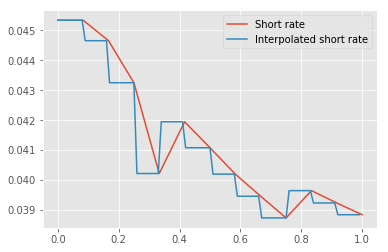

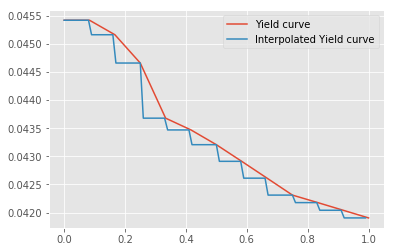

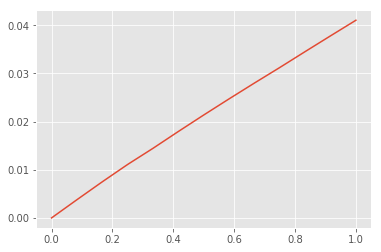

Bootstrap dividend


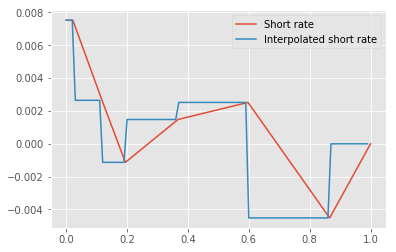

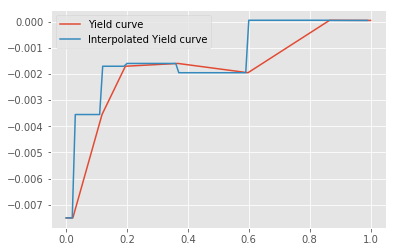

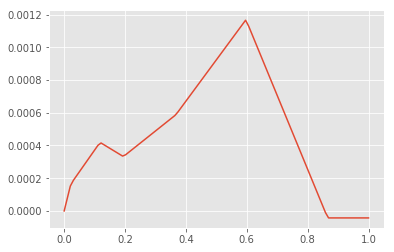

In [189]:
#Read csv files as dataFrames
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromCSV(workingFolder,
                                                                  "9_8_2001__filterdax")

#### From Dat files (DAX data)
For a day x you must load :
- "x.dat.modelparam.dat"
- "x.dat.impliedvol.dat"
- "x.dat.calibr.out.dat"
- "x.dat"

Tikhonov PDE repricing error on training set :  2.4207935408017573
Bootstrap discounting


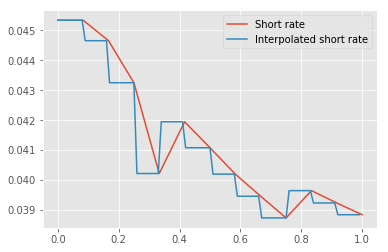

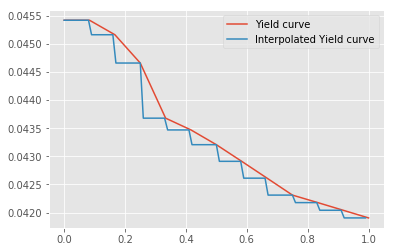

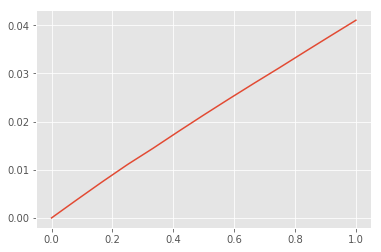

Bootstrap dividend


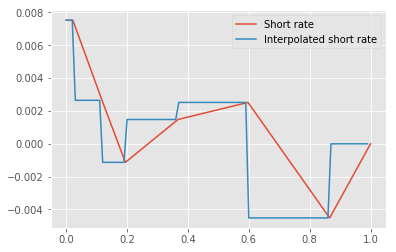

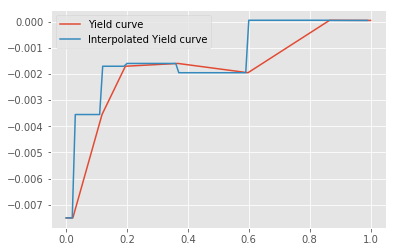

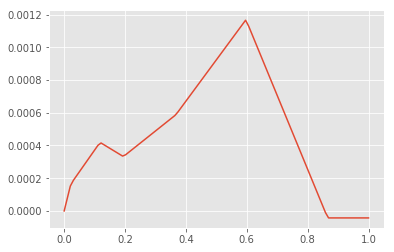

In [18]:
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromDat(workingFolder,
                                                                  "9_8_2001__filterdax")

In [88]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

In [5]:
pd.options.mode.chained_assignment = 'raise'

#### SPX Data

File required : 
- yieldCurve.dat.
- Option_SPX_18_Mai_2019Feuille2.xlsm

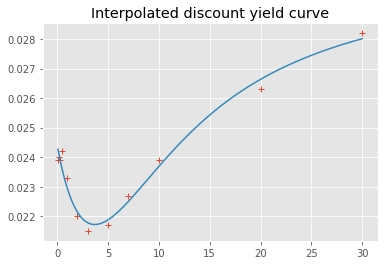

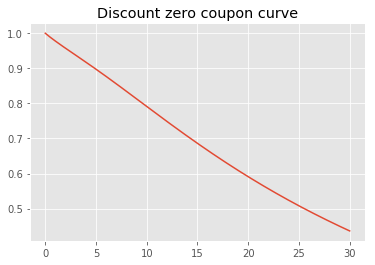

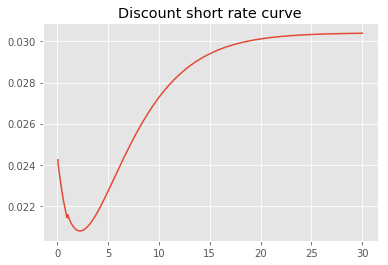

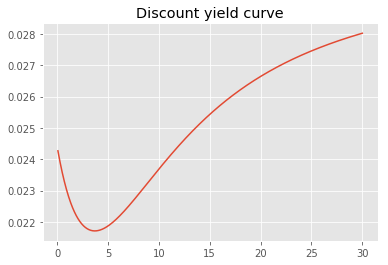

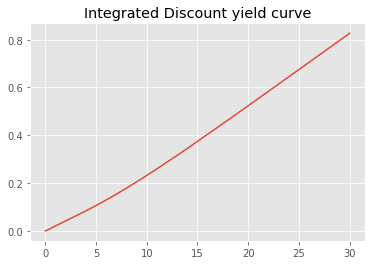

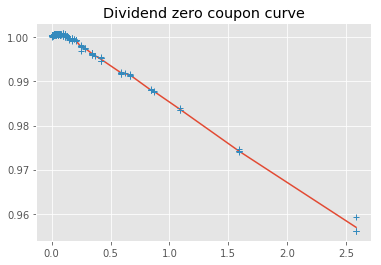

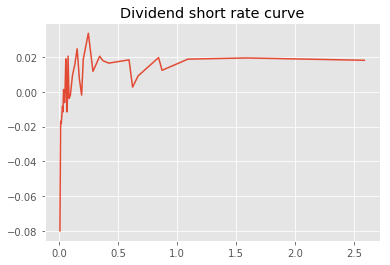

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


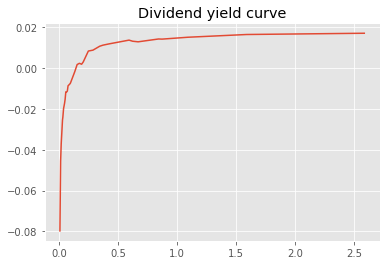

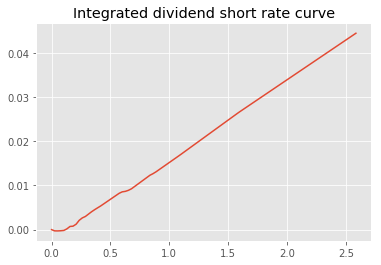

In [3]:
workingFolder = "./data/"
fileName = "Option_SPX_18_Mai_2019Feuille2.xlsm"
asOfDate = "2019-05-18"
trainingSet, testingSet, bootstrap, S0 = loadData.loadCBOTData(workingFolder, fileName, asOfDate)

In [8]:
importlib.reload(bootstrapping)

<module 'dataSetConstruction' from './code/dataSetConstruction.py'>

#### Load preformatted data

File required : 
- testingDataSet.csv
- trainingDataSet.csv
- dfCurve.csv

In [3]:
workingFolder = "./data/"
trainingSet, testingSet, bootstrap, S0 = loadData.loadFormattedData(workingFolder)

####  Eurostoxx data

File required : Data_EuroStoxx50_20190110_all_for_Marc.xlsx

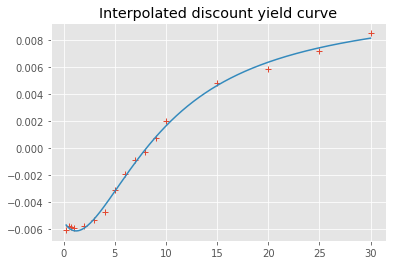

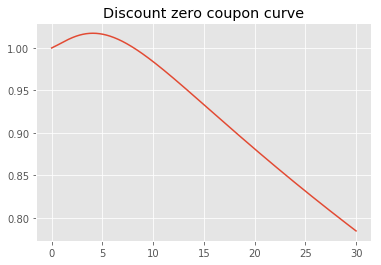

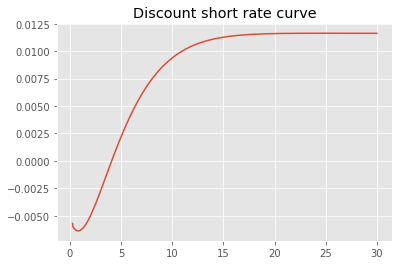

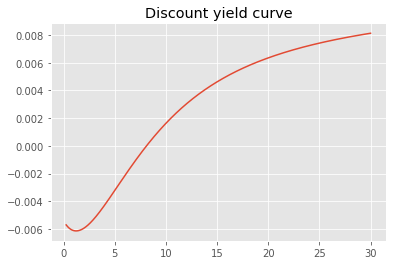

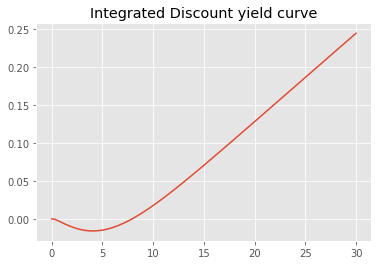

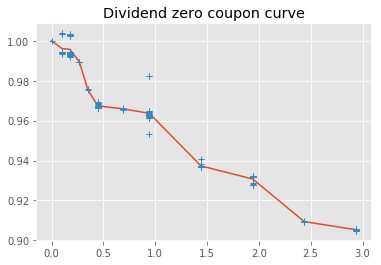

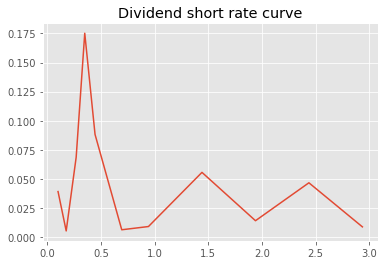

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


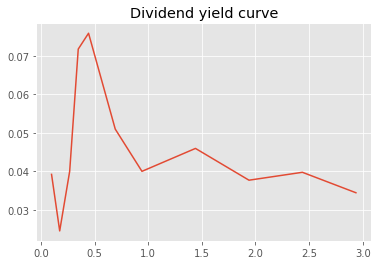

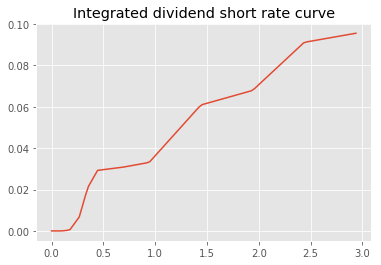

In [317]:
workingFolder = "./data/"
asOfDate = "2019-01-10"
filename = "Data_EuroStoxx50_20190110_all_for_Marc.xlsx"
trainingSet, testingSet, bootstrap, S0 = loadData.loadESXData(workingFolder, filename, asOfDate)

In [192]:
bootstrap.discountShortRate(10)

array(0.009402)

In [118]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

# Formatting data

### Boostsrapping Rate Curve

We assume a piecewise constant discount short rate $r$ and a piecewise constant dividend short rate $q$.

We estimate the "zero coupon dividend" $D(T) = e^{-\int_{0}^{T} q_s ds}$ by regressing it against maturity :
$$e^{-\int_{0}^{T} q_s ds} = \frac{C(T,K) - P(T,K) + K e^{-\int_{0}^{T} r_s ds}}{S_0}$$


Then we have $\hat{q}_t = - \frac{ \log{D(\overline{T})} - \log{D(\underline{T})} }{ \overline{T} - \underline{T} }$ with $\overline{T}$ the smallest discretized maturity greater than $T$ and $\underline{T}$ the grestest discretized maturity inferior than $T$.

bootstrap object has several members :
- **riskFreeIntegral** corresponds to $I_T = \int_{0}^{T} r_u du$.
- **riskFreeSpline**  corresponds to $r_u$ evaluated on a subgrid. Interpolated as step function from zero coupons
- **divSpreadIntegral** corresponds to $I_T = \int_{0}^{T} q_u du$, can be negative.
- **divSpline**  corresponds to $q_u$ evaluated on a subgrid, can be negative.

These curve should satisfy the call-put parity.

#### Change of variable

Neural network on modified prices with modified strike as input such that discounting and dividend don't intervene in Dupire formula calculation.


- In presence of dividend rate $d$ and risk free rate $r$ Dupire formula is :   $$\sigma^2(T,K) = 2 \frac{ \partial_T P(T,K) + (r-q) K \partial_K P(T,K) + qP(T,K)}{K² \partial_{K}^2 P(T,K)}$$ 
with Strike $K$, Maturity $T$, dividend rate $q$ and risk-free rate $r$, $P$ our pricing function. 
- We apply the following change of variable : $$ w(T,k) = \exp{(\int_{0}^{T} q_t dt)} P(T,K)$$ with $K = k \exp{(\int_{0}^{T} (r_t - q_t) dt)} $.
- Then Dupire equation becomes :  $\sigma^2(T,K) = 2 \frac{ \partial_T w(T,k)}{k² \partial_{k}^2 w(T,k)}$. 
- If we learn the mapping $v$ with a neural network then we obtain quickly by adjoint differentiation $\partial_T w$ and $\partial_{k²}^2 w$ and therefore $\sigma$.
- $k$ corresponds to "ChangedStrike" column.
- $\exp{(\int_{0}^{T} q_t dt)}$ corresponds to "DividendFactor" column.


In [1]:
#dataSetConstruction.checkCallPutParity(pd.concat([trainingSet, testingSet]), 
#                                       S0, 
#                                       bootstrap)

In [4]:
dataSet = trainingSet #Training set
dataSetTest = testingSet #Testing set
dataSet.head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
2200.0,0.419,9.95,-0.047968,184.678147,0.094049,-9.963916e-07,103.538454,2194.553900,0.994628,2200.0,0.419,0.2586,169.246997,-1.0,-0.264678,0.028020
2325.0,0.112,1.65,-0.015858,38.013410,0.027412,-3.969604e-05,73.268907,2323.142879,1.000111,2325.0,0.112,0.2958,15.762704,-1.0,-0.207736,0.009800
2400.0,0.093,1.60,-0.017779,38.199664,0.029753,-4.470370e-05,88.192154,2398.742294,1.000292,2400.0,0.093,0.2798,22.362901,-1.0,-0.175713,0.007281
2510.0,0.170,9.15,-0.074660,166.318158,0.128221,5.540400e-05,230.171845,2506.841932,0.999189,2510.0,0.170,0.2289,194.599716,-1.0,-0.131634,0.008907
2525.0,0.036,0.55,-0.010731,15.378146,0.016613,-5.456899e-05,87.679835,2524.212274,1.000312,2525.0,0.036,0.2893,6.408137,-1.0,-0.124728,0.003013


In [5]:
dataSetTest.head()

Price     Delta        Vega  Delta Strike  Gamma Strike  \
Strike Maturity                                                            
1700.0 0.246      0.80 -0.004171   17.445534      0.009788     -0.000018   
2300.0 0.419     14.30 -0.069169  246.251489      0.132054      0.000036   
2350.0 0.093      1.20 -0.013019   29.227795      0.022052     -0.000041   
       0.112      1.85 -0.018041   42.445051      0.030966     -0.000041   
2400.0 0.419     20.55 -0.099289  323.155078      0.185544      0.000106   

                      Theta  ChangedStrike  DividendFactor  Strike  Maturity  \
Strike Maturity                                                                
1700.0 0.246      15.329284    1697.643924        0.997527  1700.0     0.246   
2300.0 0.419     140.724773    2294.306350        0.994628  2300.0     0.419   
2350.0 0.093      66.591651    2348.768497        1.000292  2350.0     0.093   
       0.112      82.136307    2348.122910        1.000111  2350.0     0.112   
2400.0 0.419     187.583551    2394.058800        0.994628  2400.0     0.419   

                 ImpliedVol     VegaRef  OptionType  logMoneyness  \
Strike Maturity                                                     
1700.0 0.246         0.4147    0.062925        -1.0     -0.521416   
2300.0 0.419         0.2424  261.160274        -1.0     -0.220227   
2350.0 0.093         0.2959   11.271760        -1.0     -0.196766   
       0.112         0.2875   21.589857        -1.0     -0.197041   
2400.0 0.419         0.2264  368.610408        -1.0     -0.177667   

                 impliedTotalVariance  
Strike Maturity                        
1700.0 0.246                 0.042306  
2300.0 0.419                 0.024620  
2350.0 0.093                 0.008143  
       0.112                 0.009257  
2400.0 0.419                 0.021477

In [6]:
dfCurve = dataSetConstruction.savingData(bootstrap, 
                                         dataSet, 
                                         dataSetTest, 
                                         workingFolder)

Saving bootstrapping under dfCurve.csv
Saving training set under trainingDataSet.csv
Saving bootstrapping under testingDataSet.csv


In [7]:
threshold = pd.concat([dataSet, dataSetTest])["Price"].sort_values().iloc[int(0.05 * pd.concat([dataSet, dataSetTest]).shape[0])]
threshold

2.05

In [8]:
dataSet.shape

(135, 15)

In [9]:
dataSetTest.shape

(144, 15)

In [10]:
S0

2859.53

In [11]:
def getCall(df):
    return df[df["OptionType"]==1]
def getPut(df):
    return df[df["OptionType"]==-1]

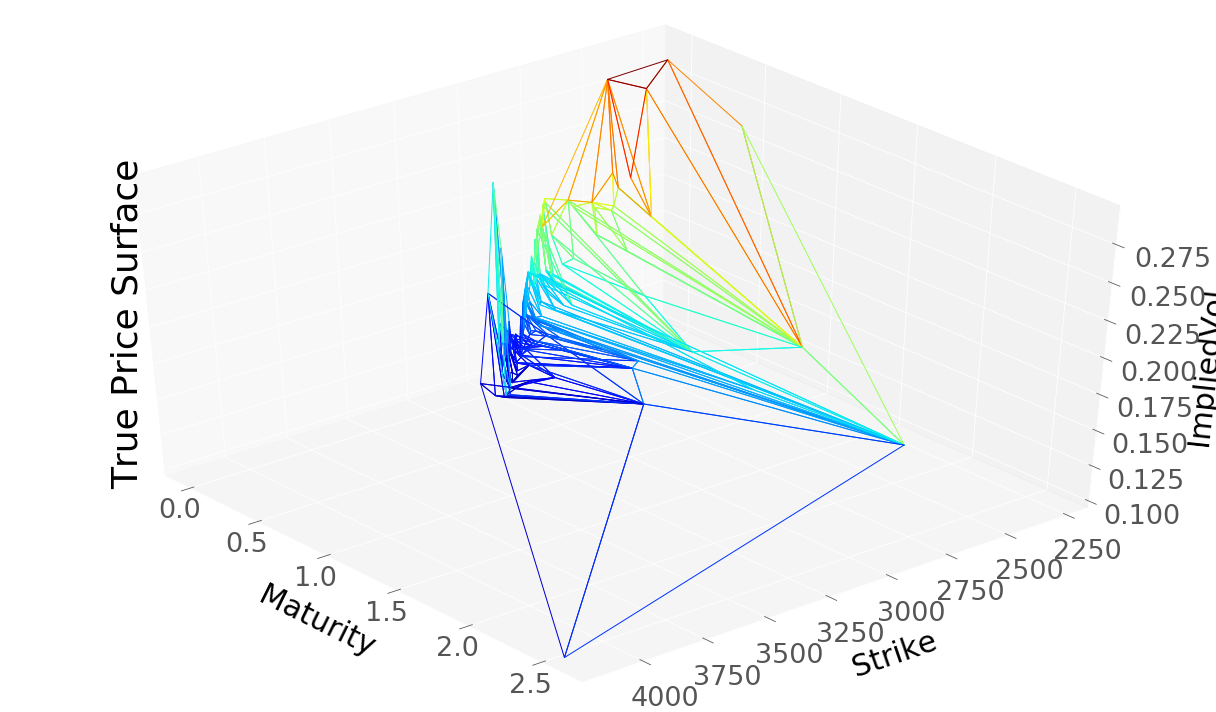

In [12]:
plotTools.plotSerie(getPut(trainingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

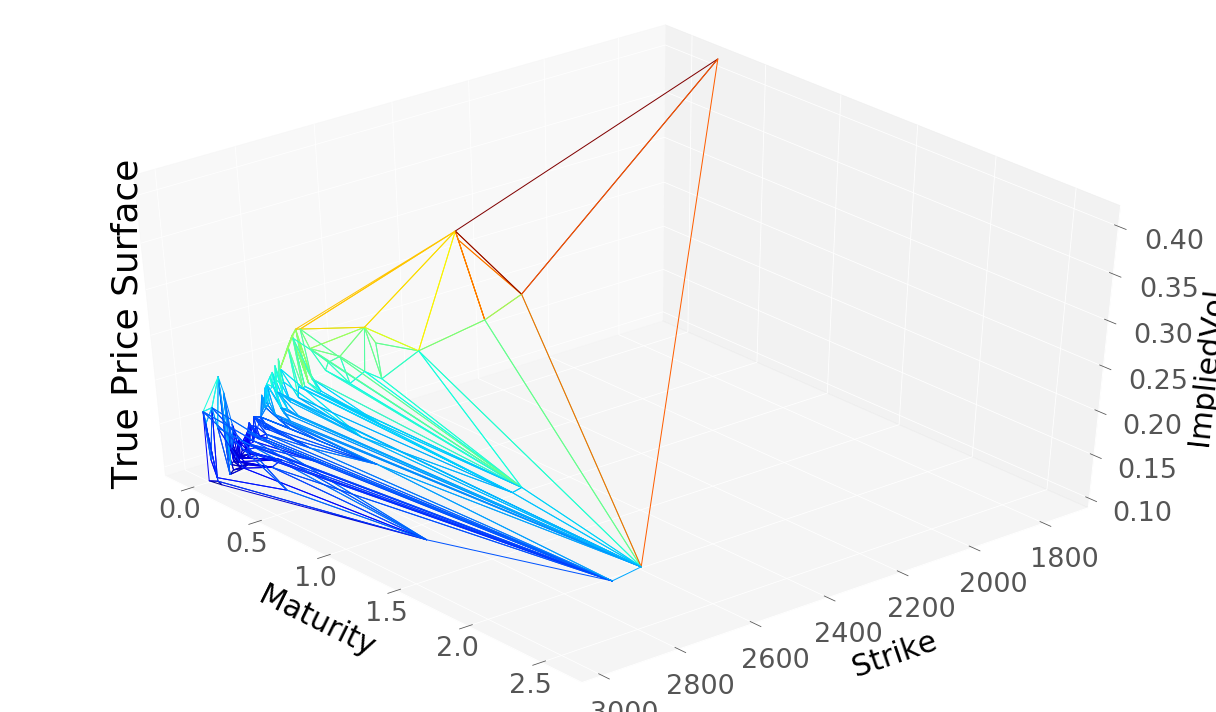

In [13]:
plotTools.plotSerie(getPut(testingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

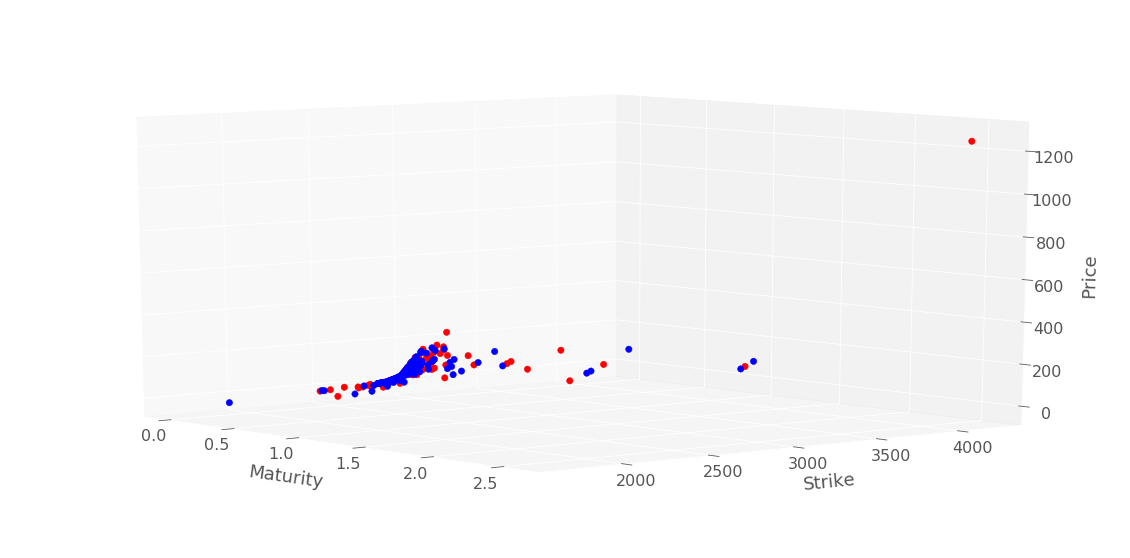

In [14]:
plotTools.plot2Series(getPut(testingSet)["Price"], 
                      getPut(trainingSet)["Price"], 
                      yMin=0,
                      yMax=3*S0, 
                      Title = 'True Price Surface')

## Scaling methods

Use min-max of scaling strike between 0 et 1 for improving stability of neural network training. 



In [15]:
activateScaling = False
transformCustom = dataSetConstruction.transformCustomMinMax if activateScaling else dataSetConstruction.transformCustomId
inverseTransform = dataSetConstruction.inverseTransformMinMax if activateScaling else dataSetConstruction.inverseTransformId
inverseTransformColumn = dataSetConstruction.inverseTransformColumnMinMax if activateScaling else dataSetConstruction.inverseTransformColumnId
inverseTransformColumnGreeks = dataSetConstruction.inverseTransformColumnGreeksMinMax if activateScaling else dataSetConstruction.inverseTransformColumnGreeksId

In [16]:
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataSet)
scaledDataSet = transformCustom(dataSet, scaler)
scaledDataSetTest = transformCustom(dataSetTest, scaler)

In [17]:
scaledDataSet.head()

,,Price,Delta,Vega,Delta Strike,Gamma Strike,Theta,ChangedStrike,DividendFactor,Strike,Maturity,ImpliedVol,VegaRef,OptionType,logMoneyness,impliedTotalVariance
Strike,Maturity,,,,,,,,,,,,,,,
2200.0,0.419,9.95,-0.047968,184.678147,0.094049,-9.963916e-07,103.538454,2194.553900,0.994628,2200.0,0.419,0.2586,169.246997,-1.0,-0.264678,0.028020
2325.0,0.112,1.65,-0.015858,38.013410,0.027412,-3.969604e-05,73.268907,2323.142879,1.000111,2325.0,0.112,0.2958,15.762704,-1.0,-0.207736,0.009800
2400.0,0.093,1.60,-0.017779,38.199664,0.029753,-4.470370e-05,88.192154,2398.742294,1.000292,2400.0,0.093,0.2798,22.362901,-1.0,-0.175713,0.007281
2510.0,0.170,9.15,-0.074660,166.318158,0.128221,5.540400e-05,230.171845,2506.841932,0.999189,2510.0,0.170,0.2289,194.599716,-1.0,-0.131634,0.008907
2525.0,0.036,0.55,-0.010731,15.378146,0.016613,-5.456899e-05,87.679835,2524.212274,1.000312,2525.0,0.036,0.2893,6.408137,-1.0,-0.124728,0.003013


In [18]:
#Search strike for ATM option
midS0 = dataSet[dataSet.index.get_level_values("Strike") >= S0].index.get_level_values("Strike").min()

In [19]:
KMin = 0#0.7 * S0[0]
KMax = 2.0 * S0#1.3 * S0[0]


# Compare backtest errors

In [28]:
importlib.reload(backtest)

<module 'backtest' from './code/backtest.py'>

In [34]:
mcResGPTest = backtest.loadMCPrices("./Results/mcResGPTest.csv", 
                                    parseHeader=0)
mcResGPTest.head()

Price    stdPrice
Strike Maturity                       
1700.0 0.246      0.833726   18.403973
2300.0 0.419     13.380419   92.245855
2350.0 0.093      0.384814   10.245258
       0.112      0.994517   18.210803
2400.0 0.419     20.646870  110.514794

In [35]:
mcResSSVITest = backtest.loadMCPrices("./Results/mcResSSVITest.csv", 
                                      parseHeader=0)
mcResSSVITest.head()

Price   stdPrice
Strike Maturity                      
1700.0 0.246      0.122353   5.334149
2300.0 0.419     13.060788  78.424282
2350.0 0.093      0.566051   9.872014
       0.112      1.066521  15.021875
2400.0 0.419     19.244920  94.333650

In [ ]:
backtest.rmse(mcResGPTest["Price"], mcResSSVITest["Price"])

In [39]:
pdeResSigmaGPTest = backtest.loadMCPrices("./Results/pdeResSigmaGPTest.csv")
pdeResSigmaGPTest.head()

2
Strike Maturity           
1700.0 0.246      0.594552
2300.0 0.419     10.923903
2350.0 0.093      0.756563
       0.112      1.130061
2400.0 0.419     19.264846

# Compare Implied Volatility and ignore miscalibrated implied volatilities

This section removes nodes where implied volatility estimation is impossible for some models (GP, NN Price).
This allow a fair comparison of implied volatility for model.

In [40]:
#Detecting options which lead to implied volatilities miscalibration
gpImpVolTraining = pd.Series(pd.read_csv("./Results" + "/GPTraining.csv").set_index(["Strike","Maturity"])["ImpliedVol"],
                             index = plotTools.removeDuplicateIndex(dataSet).index)
gpImpVolTesting = pd.Series(pd.read_csv("./Results" + "/GPTesting.csv").set_index(["Strike","Maturity"])["ImpliedVol"],
                            index = plotTools.removeDuplicateIndex(dataSetTest).index)
nnImpVolTraining = pd.Series(pd.read_csv("./Results" + "/NeuralPriceTrain.csv").set_index(["Strike","Maturity"])["ImpliedVol"],
                             index = plotTools.removeDuplicateIndex(dataSet).index)
nnImpVolTesting = pd.Series(pd.read_csv("./Results" + "/NeuralPriceTest.csv").set_index(["Strike","Maturity"])["ImpliedVol"],
                            index = plotTools.removeDuplicateIndex(dataSetTest).index)

In [41]:
gpImpVolTrainingError = gpImpVolTraining[gpImpVolTraining <= 1e-9].append(gpImpVolTraining[gpImpVolTraining >= 2])
nnImpVolTrainingError = nnImpVolTraining[nnImpVolTraining <= 1e-9].append(nnImpVolTraining[nnImpVolTraining >= 2])
trainingFilterImpVol = gpImpVolTrainingError.append(nnImpVolTrainingError).index.unique()

In [42]:
gpImpVolTestingError = gpImpVolTesting[gpImpVolTesting <= 1e-9].append(gpImpVolTesting[gpImpVolTesting >= 2])
nnImpVolTestingError = nnImpVolTesting[nnImpVolTesting <= 1e-9].append(nnImpVolTesting[nnImpVolTesting >= 2])
testingFilterImpVol = gpImpVolTestingError.append(nnImpVolTestingError).index.unique()

In [43]:
#Load results from another model
dfModelTraining = pd.read_csv("./Results" + "/NeuralImpliedVolTrain.csv").set_index(["Strike","Maturity"])
dfModelTraining = pd.DataFrame(dfModelTraining.values, 
                               index = plotTools.removeDuplicateIndex(dataSet).index,
                               columns = dfModelTraining.columns)

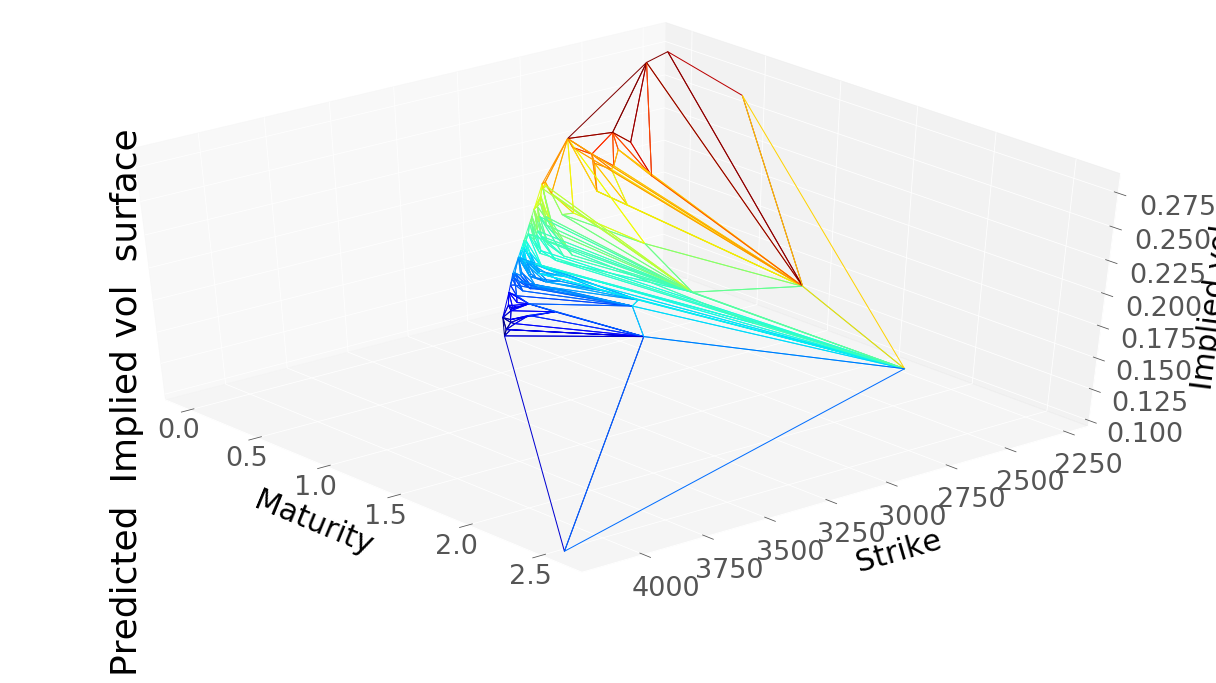

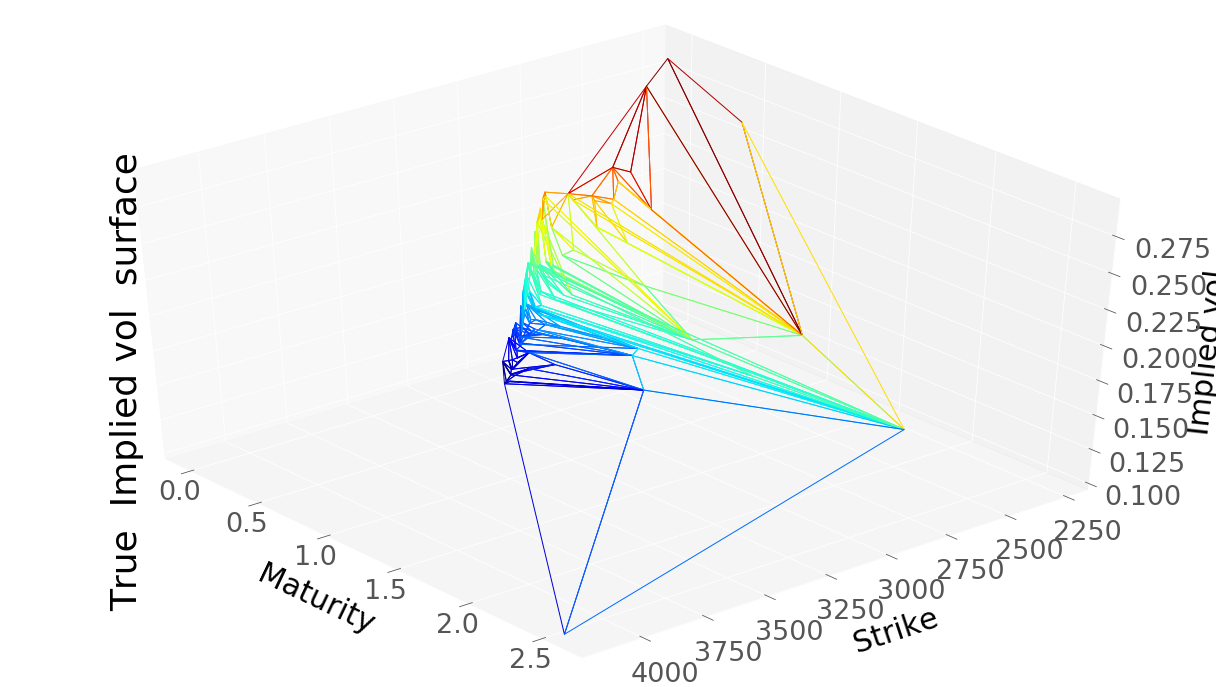

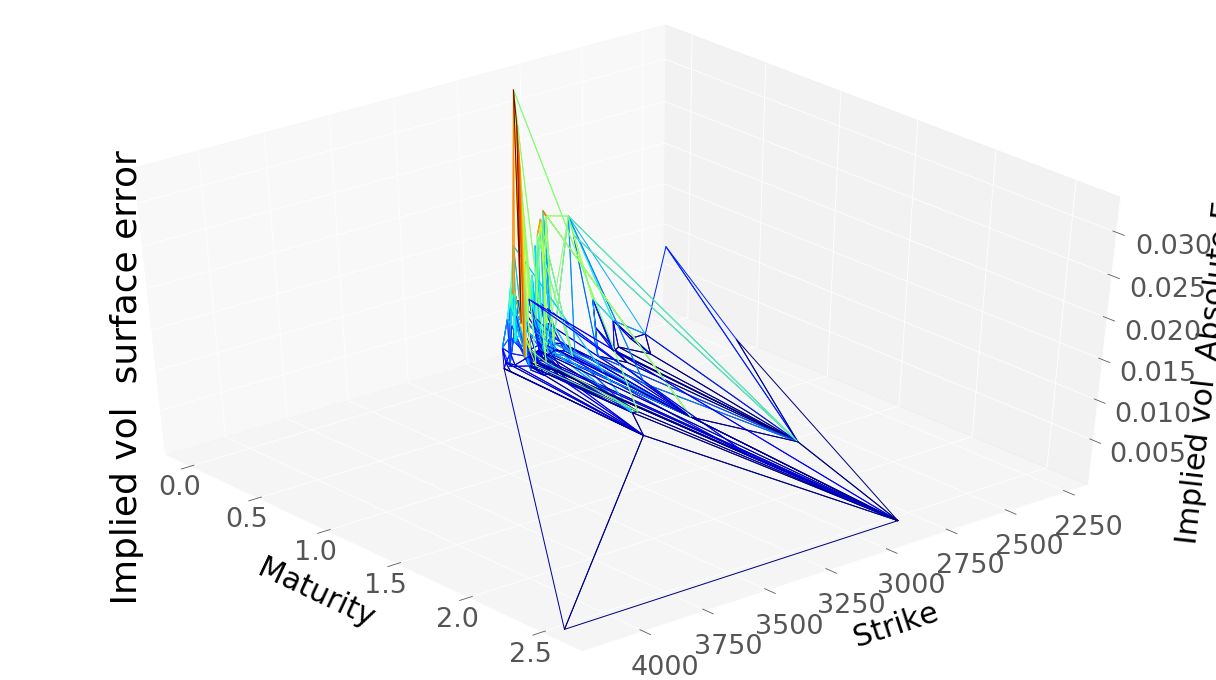

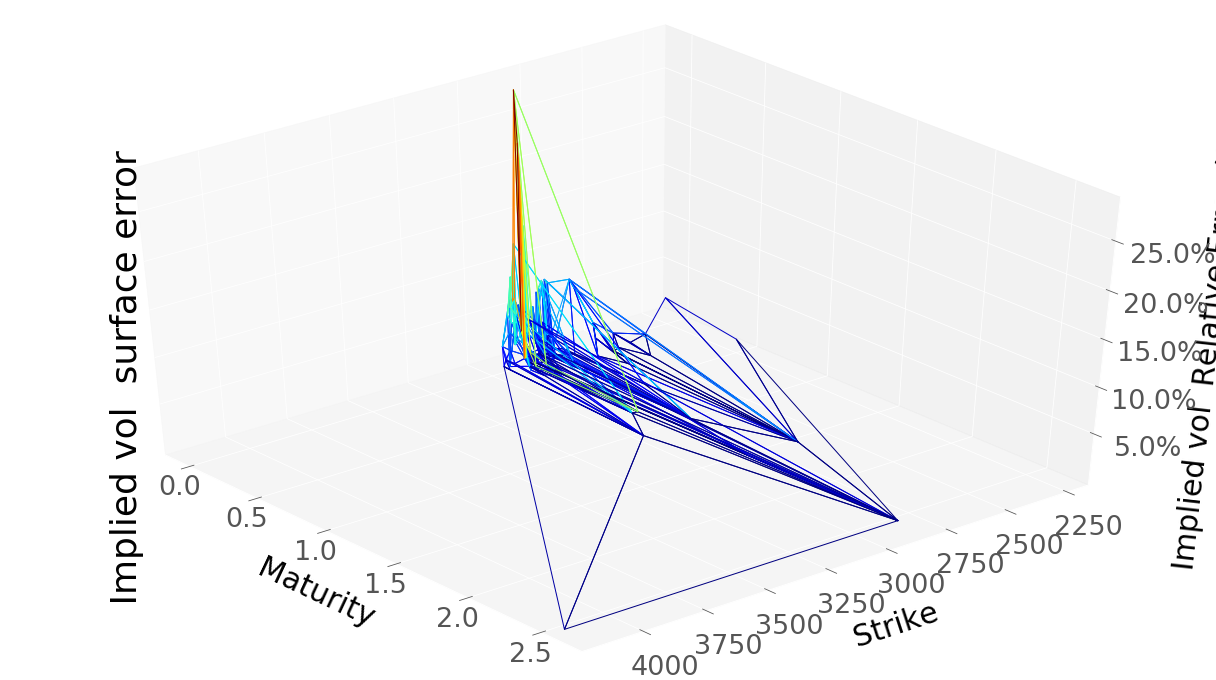

RMSE :  0.008308735683189806
RMSE Relative:  0.05839955179062345


In [44]:
keptVols = dataSet["ImpliedVol"].drop(trainingFilterImpVol).index
plotTools.predictionDiagnosis(plotTools.selectIndex(dfModelTraining["ImpliedVol"], keptVols) , 
                              plotTools.selectIndex(dataSet["ImpliedVol"], keptVols) , 
                              " Implied vol ", 
                              yMin=KMin,
                              yMax=KMax)

In [45]:
dfModelTesting = pd.read_csv("./Results" + "/NeuralImpliedVolTest.csv").set_index(["Strike","Maturity"])
dfModelTesting = pd.DataFrame(dfModelTesting.values, 
                              index = plotTools.removeDuplicateIndex(dataSetTest).index,
                              columns = dfModelTesting.columns)

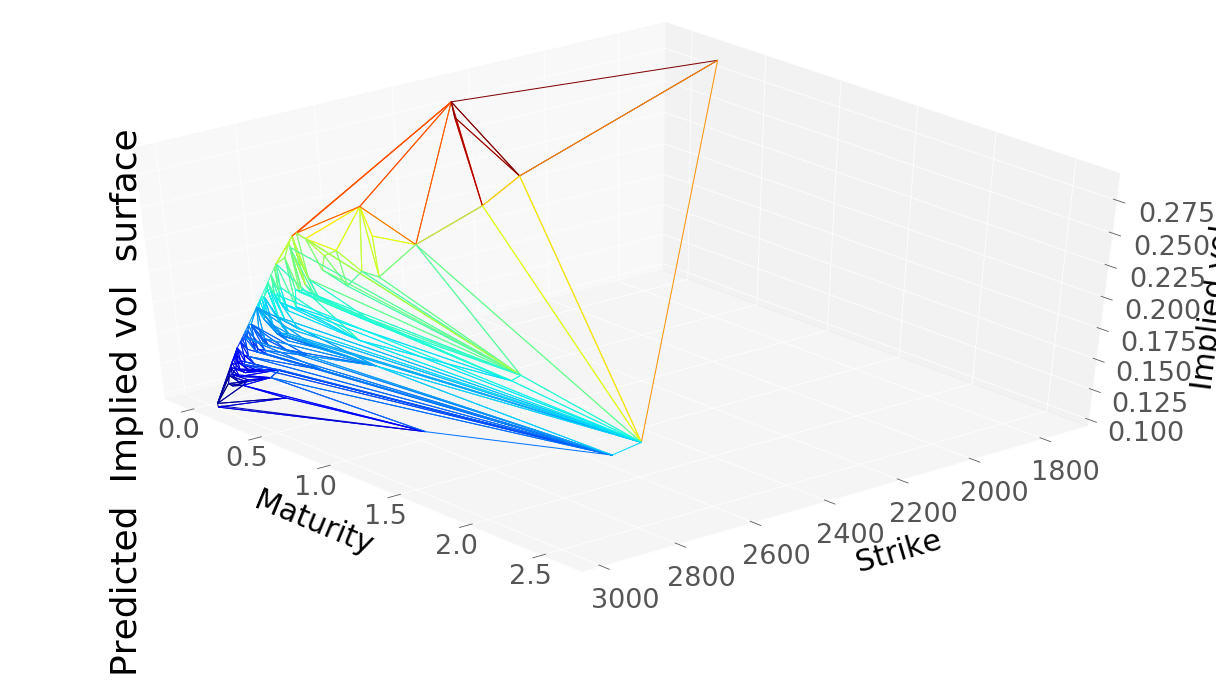

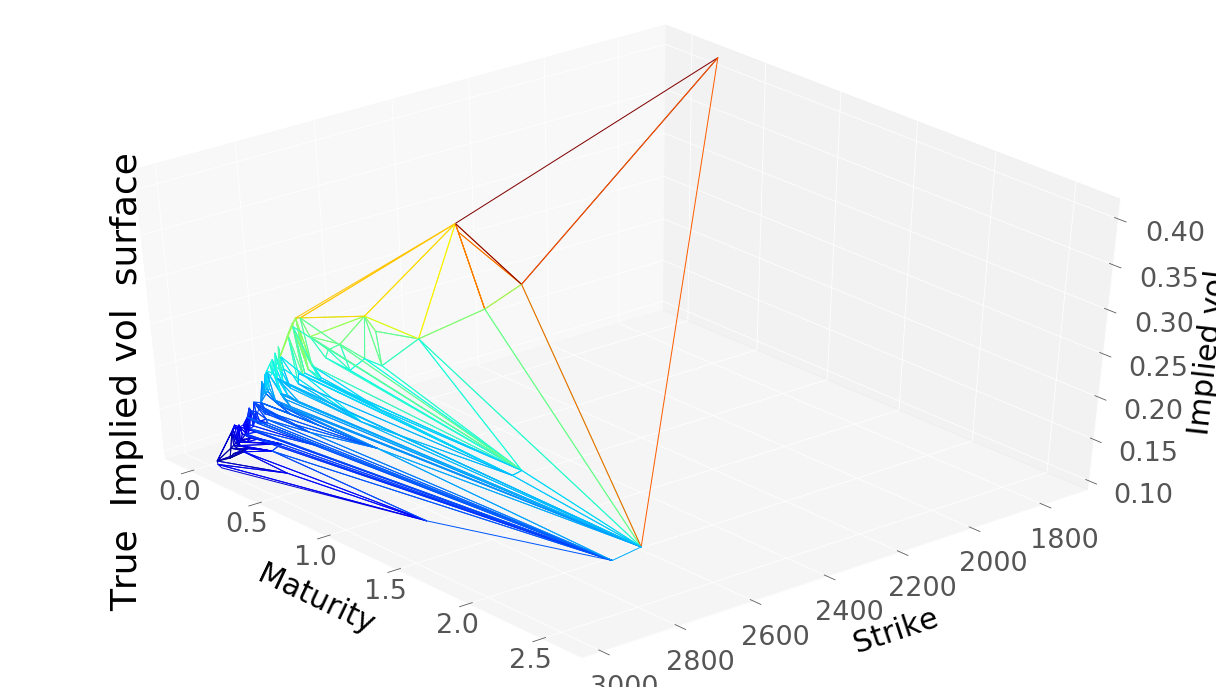

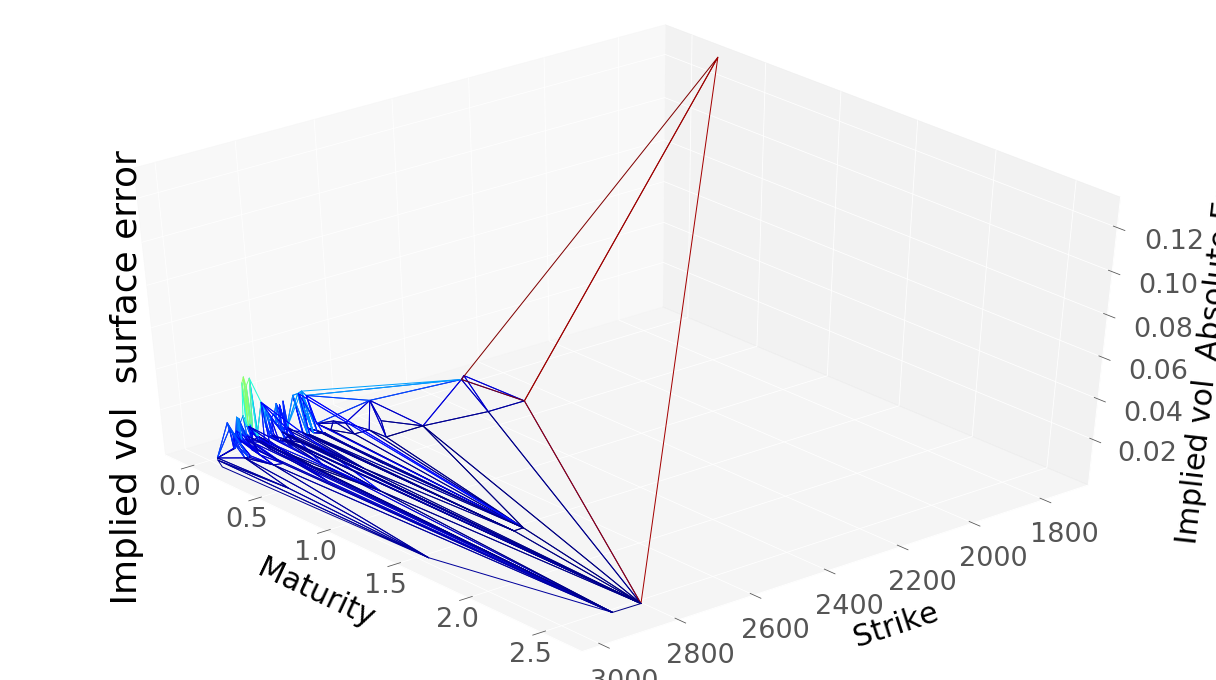

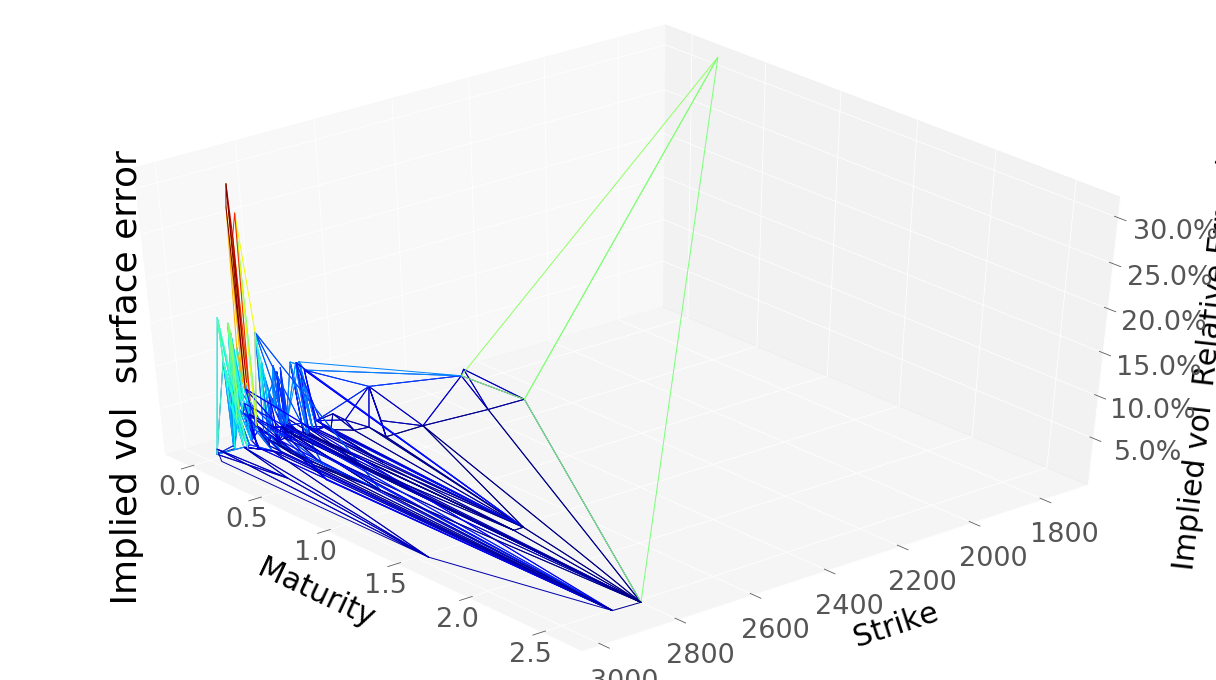

RMSE :  0.014479932896062826
RMSE Relative:  0.07272674714144238


In [46]:
keptVols = dataSetTest["ImpliedVol"].drop(testingFilterImpVol).index
plotTools.predictionDiagnosis(plotTools.selectIndex(dfModelTesting["ImpliedVol"], keptVols) , 
                              plotTools.selectIndex(dataSetTest["ImpliedVol"], keptVols) , 
                              " Implied vol ", 
                              yMin=KMin,
                              yMax=KMax)